## Figure W4-5 - Zelda and Rpb1

#### Enter filenames:

In [1]:
figuredata_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/figuredata/W4-zelda'
real_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl'
rpb1_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-rpb1-nc13-library_sJQraOLX__20220619-plussims-20220616-realreal.pkl'
zld_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220807-3xtrain-20220619-plussims-20220616-realreal.pkl'

#zld_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220813-zld-nc13-100nm-reallib_gdHIdOQQ__20220619-plussims-20220616-realreal.pkl'

#### Import libraries

In [2]:
from importlib import reload
import flymovie as fm
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from importlib import reload
import umap
import scipy.ndimage as ndi
import skimage as ski
import matplotlib.image as mpimg
%load_ext autoreload
%autoreload 2

#### Set up files, define subplotting functions.

In [3]:
embedding_real, names_real = fm.load_pickle(real_embedding_pkl)
embedding_zld_sims, names_zld_sims = fm.load_pickle(zld_sims_embedding_pkl)
zld_wt_real_vs_sim_png = os.path.join(figuredata_folder, 'zld_wt_real_vs_sim.png')
zld_mut_real_vs_sim_png = os.path.join(figuredata_folder, 'zld_mut_real_vs_sim.png')
zld_cterm_real_vs_sim_png = os.path.join(figuredata_folder, 'zld_cterm_real_vs_sim.png')
zld_wt_pairplot_png = os.path.join(figuredata_folder, 'zld_wt_pairplot.png')
zld_mut_pairplot_png = os.path.join(figuredata_folder, 'zld_mut_pairplot.png')
zld_cterm_pairplot_png = os.path.join(figuredata_folder, 'zld_cterm_pairplot.png')
outputfile_zld = os.path.join(figuredata_folder, 'fig_w4.png')

rpb1_pairplot_png = os.path.join(figuredata_folder, 'rpb1_pairplot.png')

embedding_rpb1_sims, names_rpb1_sims = fm.load_pickle(rpb1_sims_embedding_pkl)

from flymovie.figures import make_df, embeddings_match_names, dist_to_center, extract_params_df, plot_hist, make_pairplot
"""
def make_df(filenames):
    """Make a dataframe of parameters from collection of list of simulation
    filenames."""
    p = []
    for f in filenames:
        p.append(f.split('_')[1:-1])

    p = np.array(p)
    p = p.astype(float) 
    df = pd.DataFrame(p, columns=['ntotal', 'HLB diam','HLB nmols', 'n clusters', 'Cluster diam mean', 'Cluster diam sd','Cluster nmols mean','Cluster nmols sd','Noise sigma'])
    return df[['ntotal', 'HLB diam','HLB nmols', 'n clusters', 'Cluster diam mean', 'Cluster diam sd','Cluster nmols mean','Cluster nmols sd','Noise sigma']]

def embeddings_match_names(em, names, pattern):
    """Match names to a pattern, select corresponding fows of embedding."""
    if len(names) != em.shape[0]:
        raise ValueError('Sizes of embedding and names object do not match.')

    match_rows = pd.Series(names).str.contains(pattern).to_numpy()
    return em[match_rows], np.array(names)[match_rows]

def dist_to_center(ref_arr, arr):
    """Get the euclidean distance between each row of arr to center (mean) of ref_arr."""
    center = ref_arr.mean(axis=0)
    sqdist = np.sum((arr - center) ** 2, axis=1)
    return np.sqrt(sqdist)

def extract_params_df(em_ref, em_sims, names_sims, cutoff, ncols=4):
    """Extract the parameters of simulations that embed within a cutoff
    distance of the center of a reference set."""
    dists = dist_to_center(em_ref, em_sims)
    names = np.array(names_sims)[dists <= cutoff]
    df = make_df(names)
    if ncols == 4:
        return df[['n clusters',  'Cluster diam sd','Cluster nmols mean','Cluster nmols sd']]
    elif ncols == 6:
        return df[['HLB diam','HLB nmols', 'n clusters', 'Cluster diam sd','Cluster nmols mean','Cluster nmols sd']]
    elif ncols == 7:
        return df[['ntotal', 'HLB diam','HLB nmols', 'n clusters', 'Cluster diam sd','Cluster nmols mean','Cluster nmols sd','Noise sigma']]
    else:
        raise ValueError('ncols must be 4, 6, or 7.')

def plot_hist(embedding_real, names_real, embedding_sims, pattern=''):
    """Plot histograms of embeddings of simulations and selected (via pattern-matching)
    real images."""
    embedding_ref, _ = embeddings_match_names(embedding_real, names_real, pattern)
    dists_self = dist_to_center(embedding_ref, embedding_ref)
    dists_sims = dist_to_center(embedding_ref, embedding_sims)
    plt.hist(dists_self, bins=25, alpha=0.5, density=True);
    plt.hist(dists_sims, bins=25, alpha=0.5, density=True);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

def make_pairplot(embedding_real, names_real, embedding_sims, names_sims, pattern='', cutoff=np.inf, ncols=4,
    diag_kind='kde'):
    """Make a pairplot of the parameters of the sims whose embeddings are within a distance 
    cutoff of the center of the real embeddings."""
    embedding_ref, _ = embeddings_match_names(embedding_real, names_real, pattern)

    df1 = extract_params_df(embedding_ref, embedding_sims, names_sims, cutoff=cutoff, ncols=ncols)
    df2 = extract_params_df(embedding_ref, embedding_sims, names_sims, cutoff=np.inf, ncols=ncols)
    df1['sample'] = 'select'
    df2['sample'] = 'all'
    df3_ = df2.iloc[np.random.choice(np.arange(df2.shape[0]), size=np.min((10_000, df2.shape[0])), replace=False)]
    df3  = pd.concat([df3_, df1], ignore_index=True)
    print(df1.shape[0])
    g = sns.pairplot(data=df3, diag_kind=diag_kind, kind='scatter', hue='sample', plot_kws=dict(alpha=1), 
            diag_kws=dict(common_norm=False), height=2, corner=True)
    g._legend.remove()
    return df3
"""
from flymovie.figures import make_df, embeddings_match_names, dist_to_center, extract_params_df, plot_hist, make_pairplot

SyntaxError: invalid syntax (1427292144.py, line 17)

#### Make subplots, save.

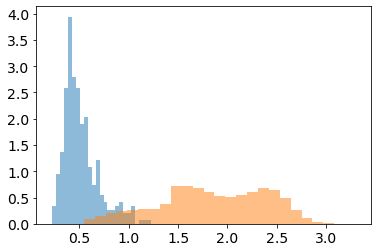

In [6]:
# Make sims vs. reals histogram for WT.
plot_hist(embedding_real, names_real, embedding_zld_sims, pattern='zld-wt.*nc13-1_|zld-wt.*nc13-2_|zld-wt.*nc13-3_|zld-wt.*nc13-4_')
plt.savefig(zld_wt_real_vs_sim_png, dpi=300)

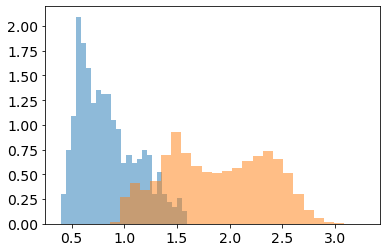

In [7]:
# Make sims vs. real histogram for mut.
pattern = 'zld-mut.*nc13-3_|zld-mut.*nc13-4_|zld-mut.*nc13-5_|zld-mut.*nc13-6_'

plot_hist(embedding_real, names_real, embedding_zld_sims, pattern)
plt.savefig(zld_mut_real_vs_sim_png, dpi=300)

In [ ]:
# Make sims vs. real histogram for cterm.
"""
pattern = 'cterm'

plot_hist(embedding_real, names_real, embedding_sims, pattern)
plt.savefig(mut_real_vs_sim_png, dpi=300)
"""

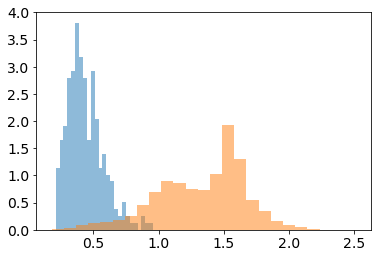

In [9]:
# Make sims vs. real histogram for rpb1.
pattern = 'rpb1.*nc13-3_|rpb1.*nc13-4_|rpb1.*nc13-5_|rpb1.*nc13-6_'

plot_hist(embedding_real, names_real, embedding_rpb1_sims, pattern)
plt.savefig(zld_mut_real_vs_sim_png, dpi=300)

2302


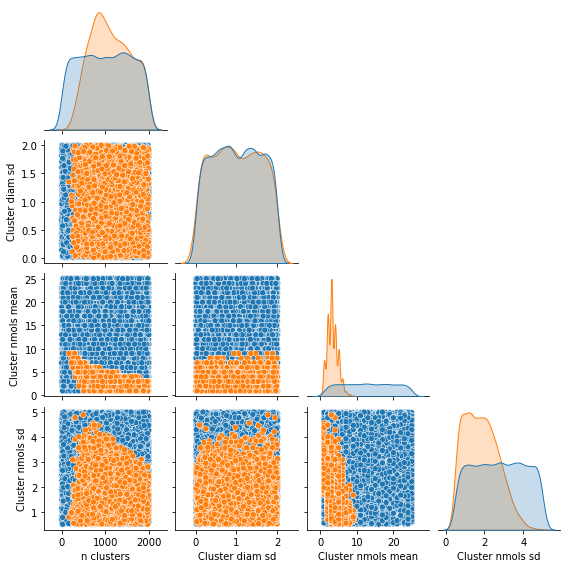

In [10]:
# Make pairplot.
pattern = 'zld-wt.*nc13-2_|zld-wt.*nc13-3_|zld-wt.*nc13-4_|zld-wt.*nc13-5_'
df = make_pairplot(embedding_real, names_real, embedding_zld_sims, names_zld_sims, pattern, cutoff=0.7, ncols=4, diag_kind='kde')
plt.savefig(zld_wt_pairplot_png, dpi=300)

212


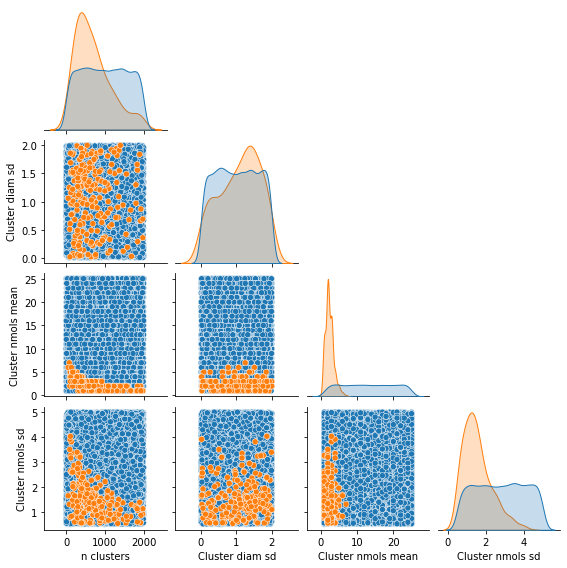

In [12]:
# Make pairplot.
pattern = 'zld-mut.*nc13-2_|zld-mut.*nc13-3_|zld-mut.*nc13-4_|zld-mut.*nc13-5_'
make_pairplot(embedding_real, names_real, embedding_zld_sims, names_zld_sims, pattern, cutoff=1, ncols=4)
plt.savefig(zld_mut_pairplot_png, dpi=300)


In [ ]:
# Make pairplot.
pattern = 'rpb1.*nc13-3_|rpb1.*nc13-4_|rpb1.*nc13-5_|rpb1.*nc13-6_'
df = make_pairplot(embedding_real, names_real, embedding_rpb1_sims, names_rpb1_sims, pattern, cutoff=0.5, ncols=7)
#plt.savefig(rpb1_pairplot_png, dpi=300)

In [ ]:
df_sub = df[df['sample'] == 'select']
df_sub
sns.histplot(df_sub['Noise sigma'])

### Lay out figure.

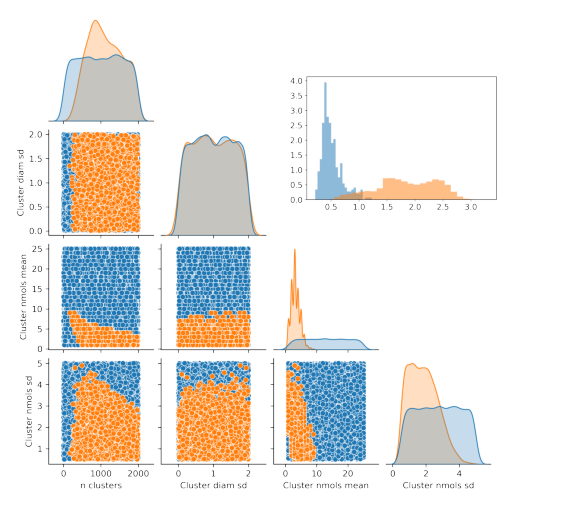

In [13]:
fig = plt.figure(constrained_layout=False, facecolor='1', figsize=(8.48,12))

plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -2

ax0 = fig.add_axes((0.05,0.35,0.9,0.9/1.41))
img = mpimg.imread(zld_wt_pairplot_png)
ax0.imshow(img, aspect='equal')
ax0.axis('off')


ax = fig.add_axes((0.49,0.66,0.40,0.40/1.41))
img = mpimg.imread(zld_wt_real_vs_sim_png)
ax.imshow(img, aspect='equal')
ax.axis('off')

fig.savefig(outputfile_zld,dpi=200)

In [ ]:
?sns.PairGrid

In [ ]:
def make_hist_series(embedding_real, names_real, embedding_sims, names_sims, patterns, param, cutoff=np.inf):
    """."""
    print(len(patterns))
    fig, axes = plt.subplots(1, len(patterns), figsize=(8 * len(patterns), 12))
    dfs = []
    max = 0
    for i in range(len(patterns)):
        pattern = patterns[i]
        embedding_ref, _ = embeddings_match_names(embedding_real, names_real, pattern)
        df = extract_params_df(embedding_ref, embedding_sims, names_sims, cutoff=cutoff, ncols=7)
        print(df.shape)
        dfs.append(df)
        max_thisset = np.max(df[param])
        if max_thisset > max:
            max = max_thisset

    for i in range(len(patterns)):       
        axes[i].hist(dfs[i][param], bins=20, range=(0,max));

patterns = [
    'zld-wt.*nc13-1_','zld-wt.*nc13-2_','zld-wt.*nc13-3_','zld-wt.*nc13-4_','zld-wt.*nc13-5_', 
    'zld-wt.*nc13-6_','zld-wt.*nc13-7_'
]


#make_hist_series(embedding_real, names_real, embedding_sims, patterns=patterns, param='n clusters', cutoff=0.5)

In [ ]:
a = pd.DataFrame(np.random.random((10,2)))
a.loc[a[0] > 0]

In [ ]:
def make_scatter_series(embedding_real, names_real, embedding_sims, names_sims, patterns, params, cutoff=np.inf):
    """."""
    fig, axes = plt.subplots(1, len(patterns), figsize=(8 * len(patterns), 8))
    dfs = []
    for i in range(len(patterns)):
        pattern = patterns[i]
        embedding_ref, _ = embeddings_match_names(embedding_real, names_real, pattern)
        df = extract_params_df(embedding_ref, embedding_sims, names_sims, cutoff=cutoff, ncols=7)
        print(df.shape)
        dfs.append(df)

    df_all = df = extract_params_df(embedding_ref, embedding_sims, names_sims, cutoff=np.inf, ncols=7)
    df_all['sample'] = 'all'
    df_all = df_all.iloc[np.random.choice(np.arange(df_all.shape[0]), size=10_000, replace=False)]
    
    for i in range(len(patterns)):
        dfs[i]['sample'] = 'select'
        df_i  = pd.concat([df_all, dfs[i]], ignore_index=True)
        g = sns.scatterplot(data=df_i, x=params[0], y=params[1], hue='sample', ax=axes[i], legend=False, s=300, alpha=0.5);
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')



In [ ]:
patterns = [
    'zld-wt.*nc13-1_','zld-wt.*nc13-2_','zld-wt.*nc13-3_','zld-wt.*nc13-4_','zld-wt.*nc13-5_', 
    'zld-wt.*nc13-6_','zld-wt.*nc13-7_'
]

make_scatter_series(embedding_real, names_real, embedding_zld_sims, names_zld_sims, patterns=patterns, params=['n clusters', 'Cluster nmols sd'], cutoff=0.5)

In [ ]:
patterns = [
    'rpb1.*nc13-1_','rpb1.*nc13-2_','rpb1.*nc13-3_','rpb1.*nc13-4_','rpb1.*nc13-5_', 
    'rpb1.*nc13-6_','rpb1.*nc13-7_'
]

make_scatter_series(embedding_real, names_real, embedding_rpb1_sims, names_rpb1_sims, patterns=patterns, params=['n clusters', 'Cluster nmols mean'], cutoff=0.4)

In [ ]:
# Make pairplot.
pattern = 'rpb.*nc13-3_|rpb.*nc13-4_|rpb.*nc13-5_|rpb.*nc13-6_'
make_pairplot(embedding_real, names_real, embedding_rpb1_sims, names_rpb1_sims, pattern, cutoff=0.4, ncols=4)
#plt.savefig(zld_mut_pairplot_png, dpi=300)

In [ ]:
patterns = [
    'rpb1.*nc13-1_','rpb1.*nc13-2_','rpb1.*nc13-3_','rpb1.*nc13-4_','rpb1.*nc13-5_', 
    'rpb1.*nc13-6_','rpb1.*nc13-7_'
]

patterns = [
    'rpb1.*nc13-3_'
]

make_scatter_series(embedding_real, names_real, embedding_sims, patterns=patterns, params=['n clusters', 'Cluster nmols sd'], cutoff=np.inf)

In [ ]:
def make_hist_series(embedding_real, names_real, embedding_sims, names_sims, patterns, param, cutoff=np.inf):
    """."""
    print(len(patterns))
    fig, axes = plt.subplots(1, len(patterns), figsize=(8 * len(patterns), 12))
    dfs = []
    max = 0
    for i in range(len(patterns)):
        pattern = patterns[i]
        embedding_ref, _ = embeddings_match_names(embedding_real, names_real, pattern)
        df = extract_params_df(embedding_ref, embedding_sims, names_sims, cutoff=cutoff, ncols=7)
        print(df.shape)
        dfs.append(df)
        max_thisset = np.max(df[param])
        if max_thisset > max:
            max = max_thisset

    for i in range(len(patterns)):       
        #axes[i].hist(dfs[i][param], bins=20, range=(0,max), density=True);
        sns.kdeplot(dfs[i][param], ax=axes[i], shade='fill', clip=(0.0, max))

patterns = [
    'rpb1.*nc13-1_','rpb1.*nc13-2_','rpb1.*nc13-3_','rpb1.*nc13-4_','rpb1.*nc13-5_', 
    'rpb1.*nc13-6_','rpb1.*nc13-7_'
]

make_hist_series(embedding_real, names_real, embedding_rpb1_sims, names_rpb1_sims, patterns=patterns, param='n clusters', cutoff=0.4)

In [ ]:
?sns.kdeplot